In [575]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [576]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [577]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)

    return (data)

In [578]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [579]:
prep = preprocess(data, ada=True)

In [580]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [581]:
model = xgb.XGBClassifier(learning_rate = 0.015,
                          subsample=0.8,
                          colsample_bytree=0.5,
                          colsample_bylevel=0.8,
                          scale_pos_weight=0.69,
                          random_state=42,
                          max_depth=8,
                          booster = 'gbtree',
                          objective = 'binary:logistic',
                          n_estimators = 5000)

In [582]:
model.fit(x_train.drop(target, axis = 1), 
          y_train, eval_metric = 'logloss', 
          eval_set=[(x_test.drop(target, axis = 1), y_test)], 
          early_stopping_rounds = 200)

[0]	validation_0-logloss:0.68011
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.672439
[2]	validation_0-logloss:0.65998
[3]	validation_0-logloss:0.64773
[4]	validation_0-logloss:0.640328
[5]	validation_0-logloss:0.63354
[6]	validation_0-logloss:0.626478
[7]	validation_0-logloss:0.615263
[8]	validation_0-logloss:0.604579
[9]	validation_0-logloss:0.594049
[10]	validation_0-logloss:0.588009
[11]	validation_0-logloss:0.582284
[12]	validation_0-logloss:0.57626
[13]	validation_0-logloss:0.56639
[14]	validation_0-logloss:0.556939
[15]	validation_0-logloss:0.547678
[16]	validation_0-logloss:0.538671
[17]	validation_0-logloss:0.529895
[18]	validation_0-logloss:0.525529
[19]	validation_0-logloss:0.517059
[20]	validation_0-logloss:0.508656
[21]	validation_0-logloss:0.500547
[22]	validation_0-logloss:0.492515
[23]	validation_0-logloss:0.48814
[24]	validation_0-logloss:0.480458
[25]	validation_0-logloss:0.476282
[26]	validation_0-logloss:0.472515
[27

[230]	validation_0-logloss:0.116088
[231]	validation_0-logloss:0.115486
[232]	validation_0-logloss:0.115248
[233]	validation_0-logloss:0.114618
[234]	validation_0-logloss:0.113979
[235]	validation_0-logloss:0.113385
[236]	validation_0-logloss:0.112775
[237]	validation_0-logloss:0.11263
[238]	validation_0-logloss:0.112047
[239]	validation_0-logloss:0.111893
[240]	validation_0-logloss:0.111676
[241]	validation_0-logloss:0.111463
[242]	validation_0-logloss:0.110929
[243]	validation_0-logloss:0.110804
[244]	validation_0-logloss:0.11023
[245]	validation_0-logloss:0.109702
[246]	validation_0-logloss:0.109535
[247]	validation_0-logloss:0.109311
[248]	validation_0-logloss:0.108754
[249]	validation_0-logloss:0.108549
[250]	validation_0-logloss:0.108409
[251]	validation_0-logloss:0.107902
[252]	validation_0-logloss:0.107404
[253]	validation_0-logloss:0.107236
[254]	validation_0-logloss:0.107106
[255]	validation_0-logloss:0.106667
[256]	validation_0-logloss:0.106476
[257]	validation_0-logloss:0.1

[459]	validation_0-logloss:0.075054
[460]	validation_0-logloss:0.074948
[461]	validation_0-logloss:0.074813
[462]	validation_0-logloss:0.074717
[463]	validation_0-logloss:0.074611
[464]	validation_0-logloss:0.07458
[465]	validation_0-logloss:0.074465
[466]	validation_0-logloss:0.074351
[467]	validation_0-logloss:0.074274
[468]	validation_0-logloss:0.074162
[469]	validation_0-logloss:0.074126
[470]	validation_0-logloss:0.074049
[471]	validation_0-logloss:0.073997
[472]	validation_0-logloss:0.07388
[473]	validation_0-logloss:0.073765
[474]	validation_0-logloss:0.073738
[475]	validation_0-logloss:0.073636
[476]	validation_0-logloss:0.07355
[477]	validation_0-logloss:0.073473
[478]	validation_0-logloss:0.073426
[479]	validation_0-logloss:0.073339
[480]	validation_0-logloss:0.073323
[481]	validation_0-logloss:0.073268
[482]	validation_0-logloss:0.073226
[483]	validation_0-logloss:0.073161
[484]	validation_0-logloss:0.073122
[485]	validation_0-logloss:0.073049
[486]	validation_0-logloss:0.07

[688]	validation_0-logloss:0.06435
[689]	validation_0-logloss:0.064331
[690]	validation_0-logloss:0.064291
[691]	validation_0-logloss:0.064252
[692]	validation_0-logloss:0.064216
[693]	validation_0-logloss:0.064164
[694]	validation_0-logloss:0.064143
[695]	validation_0-logloss:0.064126
[696]	validation_0-logloss:0.064125
[697]	validation_0-logloss:0.064115
[698]	validation_0-logloss:0.064097
[699]	validation_0-logloss:0.064069
[700]	validation_0-logloss:0.064046
[701]	validation_0-logloss:0.063994
[702]	validation_0-logloss:0.063945
[703]	validation_0-logloss:0.063932
[704]	validation_0-logloss:0.063917
[705]	validation_0-logloss:0.063895
[706]	validation_0-logloss:0.063864
[707]	validation_0-logloss:0.063829
[708]	validation_0-logloss:0.063808
[709]	validation_0-logloss:0.063806
[710]	validation_0-logloss:0.063789
[711]	validation_0-logloss:0.063794
[712]	validation_0-logloss:0.063769
[713]	validation_0-logloss:0.063762
[714]	validation_0-logloss:0.063764
[715]	validation_0-logloss:0.

[917]	validation_0-logloss:0.060933
[918]	validation_0-logloss:0.060946
[919]	validation_0-logloss:0.060936
[920]	validation_0-logloss:0.06092
[921]	validation_0-logloss:0.060932
[922]	validation_0-logloss:0.060934
[923]	validation_0-logloss:0.060921
[924]	validation_0-logloss:0.060907
[925]	validation_0-logloss:0.060915
[926]	validation_0-logloss:0.060912
[927]	validation_0-logloss:0.060907
[928]	validation_0-logloss:0.060899
[929]	validation_0-logloss:0.060894
[930]	validation_0-logloss:0.060898
[931]	validation_0-logloss:0.06089
[932]	validation_0-logloss:0.060896
[933]	validation_0-logloss:0.060872
[934]	validation_0-logloss:0.060881
[935]	validation_0-logloss:0.060882
[936]	validation_0-logloss:0.060875
[937]	validation_0-logloss:0.060864
[938]	validation_0-logloss:0.060866
[939]	validation_0-logloss:0.060866
[940]	validation_0-logloss:0.060859
[941]	validation_0-logloss:0.060846
[942]	validation_0-logloss:0.060859
[943]	validation_0-logloss:0.060876
[944]	validation_0-logloss:0.0

[1142]	validation_0-logloss:0.060284
[1143]	validation_0-logloss:0.060268
[1144]	validation_0-logloss:0.060275
[1145]	validation_0-logloss:0.060269
[1146]	validation_0-logloss:0.060263
[1147]	validation_0-logloss:0.060259
[1148]	validation_0-logloss:0.060261
[1149]	validation_0-logloss:0.060269
[1150]	validation_0-logloss:0.060274
[1151]	validation_0-logloss:0.060265
[1152]	validation_0-logloss:0.060265
[1153]	validation_0-logloss:0.060267
[1154]	validation_0-logloss:0.060274
[1155]	validation_0-logloss:0.060282
[1156]	validation_0-logloss:0.060295
[1157]	validation_0-logloss:0.060309
[1158]	validation_0-logloss:0.060309
[1159]	validation_0-logloss:0.060314
[1160]	validation_0-logloss:0.060339
[1161]	validation_0-logloss:0.060333
[1162]	validation_0-logloss:0.06033
[1163]	validation_0-logloss:0.06033
[1164]	validation_0-logloss:0.060342
[1165]	validation_0-logloss:0.060353
[1166]	validation_0-logloss:0.060348
[1167]	validation_0-logloss:0.060333
[1168]	validation_0-logloss:0.060317
[11

[1364]	validation_0-logloss:0.060362
[1365]	validation_0-logloss:0.060368
[1366]	validation_0-logloss:0.060371
[1367]	validation_0-logloss:0.060369
[1368]	validation_0-logloss:0.06036
[1369]	validation_0-logloss:0.060362
[1370]	validation_0-logloss:0.060372
[1371]	validation_0-logloss:0.060369
[1372]	validation_0-logloss:0.060372
[1373]	validation_0-logloss:0.060374
[1374]	validation_0-logloss:0.060377
[1375]	validation_0-logloss:0.060396
[1376]	validation_0-logloss:0.060378
[1377]	validation_0-logloss:0.060373
[1378]	validation_0-logloss:0.060378
[1379]	validation_0-logloss:0.060367
[1380]	validation_0-logloss:0.060364
[1381]	validation_0-logloss:0.060376
[1382]	validation_0-logloss:0.060356
[1383]	validation_0-logloss:0.060361
[1384]	validation_0-logloss:0.060368
[1385]	validation_0-logloss:0.06036
[1386]	validation_0-logloss:0.060362
[1387]	validation_0-logloss:0.060343
[1388]	validation_0-logloss:0.060336
[1389]	validation_0-logloss:0.06033
[1390]	validation_0-logloss:0.060326
[139

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.5, gamma=0, learning_rate=0.015,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=5000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.69, seed=None, silent=True,
       subsample=0.8)

In [583]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [584]:
x_test.Stage.head(10)

2040     0.0
4069     0.0
4230     1.0
578      1.0
12594    0.0
6042     1.0
2763     0.0
15900    0.0
2669     1.0
12802    0.0
Name: Stage, dtype: float64

In [585]:
res = y_pred[:,1]

In [586]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [587]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [588]:
log_loss(answer["Stage"], answer["Prediction"])

0.06882094436325067

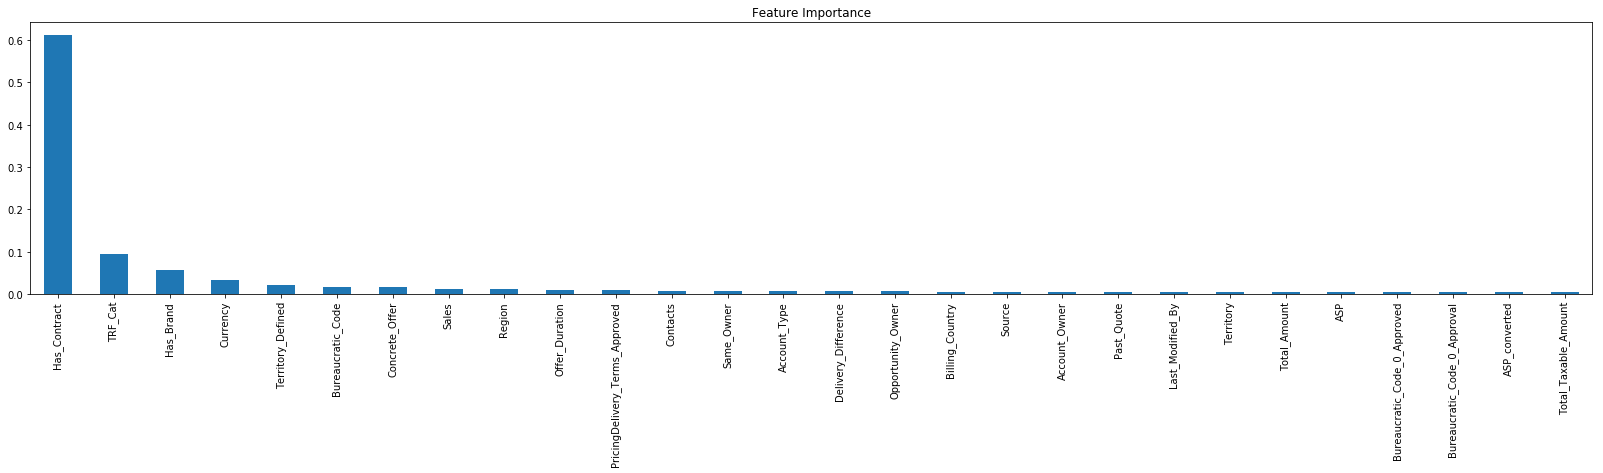

In [589]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [591]:
print feat_imp

Has_Contract                      0.611617
TRF_Cat                           0.093916
Has_Brand                         0.057801
Currency                          0.032577
Territory_Defined                 0.022456
Bureaucratic_Code                 0.017066
Concrete_Offer                    0.016037
Sales                             0.012595
Region                            0.011379
Offer_Duration                    0.009563
PricingDelivery_Terms_Approved    0.009158
Contacts                          0.007576
Same_Owner                        0.007147
Account_Type                      0.006273
Delivery_Difference               0.006100
Opportunity_Owner                 0.006087
Billing_Country                   0.005698
Source                            0.005483
Account_Owner                     0.005351
Past_Quote                        0.005281
Last_Modified_By                  0.005186
Territory                         0.005114
Total_Amount                      0.004945
ASP        

In [598]:
vali = pd.read_csv("Validacion_ECI_2020.csv")

In [600]:
validation = preprocess(vali, ada = True)

In [613]:
len(validation[validation.Contacts > 0])

2551

In [593]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))

In [594]:
pred_vali = pred[:,1]

In [595]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [596]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [597]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9958843813564603

In [82]:
#answer.to_csv("best/model_xgboost_pred.csv", index = False, header = False)